In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import urbanpy as up

In [2]:
import contextily as cx

In [3]:
# Download district boundaries
surquillo = up.download.nominatim_osm('surquillo')
surquillo.crs = 'EPSG:4326'

In [4]:
# Official restaurants reported by the city council
restaurantes = gpd.read_file("inputs/restaurante/SHP_RESTAURANTES_SURQUILLO.shp")
restaurantes_gpd = restaurantes.to_crs(crs="EPSG:4326")

In [5]:
# Traditional markets national survey 2016
mercados = pd.read_csv('inputs/database_mercadosINEI.csv')

# Fix coordinates
mercados_lat_correct = mercados.latitude[mercados.latitude < -12.485] / 1e+6
mercados.loc[mercados_lat_correct.index, 'latitude'] = mercados_lat_correct.values

mercados_long_correct = mercados.longitude[mercados.longitude < -77.175] / 1e+6
mercados.loc[mercados_long_correct.index, 'longitude'] = mercados_long_correct.values

mercados_geometry = gpd.points_from_xy(mercados.longitude, mercados.latitude, crs='EPSG:4326')

mercados_gdf = gpd.GeoDataFrame(mercados, geometry=mercados_geometry)

mercados_gdf = mercados_gdf[mercados_gdf.within(surquillo.geometry[0])] # Filter markets in surquillo

In [6]:
# Georreferenced venezuelan inmigrant food security survey
encuestas_df = pd.read_csv('inputs/complete_survey.csv')
encuestas = gpd.GeoDataFrame(encuestas_df,
                             geometry=gpd.points_from_xy(encuestas_df.lon, encuestas_df.lat),
                             crs='EPSG:4326')
encuestas = encuestas[encuestas.within(surquillo.geometry[0])] # Filter surveys in surquillo

In [7]:
print('Observations count per dataset')
print("# Restaurants ", restaurantes_gpd.shape[0])
print("# Encuestas ", encuestas.shape[0])
print("# Traditional markets ", mercados_gdf.shape[0])

Observations count per dataset
# Restaurants  618
# Encuestas  366
# Traditional markets  14


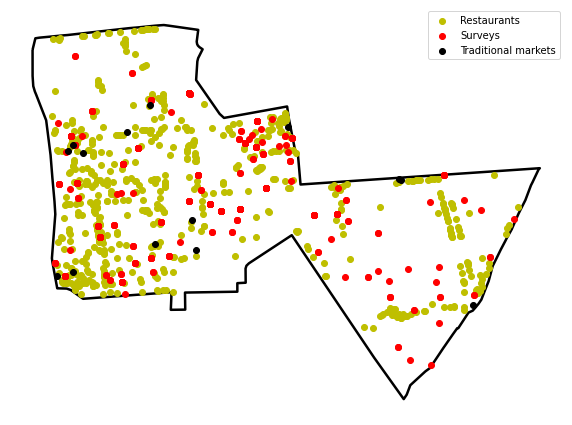

In [8]:
ax = surquillo.plot(color='none', linewidth=2.5, figsize=(10,15))

restaurantes_gpd.plot(ax=ax, color='y', label='Restaurants')
encuestas.plot(ax=ax, color='r', label='Surveys')
mercados_gdf.plot(ax=ax, color='k', label='Traditional markets')

ax.legend() 
#cx.add_basemap(ax)
ax.set_axis_off()

### Calculating a Vulnerability Index

In [9]:
# The *number of familiy members* is needed to calculate Monetary & Laboral vulnerability indexes
# Since this number wasnt asked in the survey, an estimation is done using members ages or genders

age_cols = ['edad', 'edad_1', 'edad_2', 'edad_3', 'edad_4', 'edad_5', 'edad_6', 'edad_7', 'edad_8', 'edad_9']
gender_cols = ['sexo', 'sexo_1', 'sexo_2', 'sexo_3', 'sexo_4', 'sexo_5', 'sexo_6', 'sexo_7', 'sexo_8', 'sexo_9']

# Count non empty responses
fam_members_age = (~encuestas[age_cols].isna()).sum(axis=1)
fam_members_gender = (~encuestas[gender_cols].isna()).sum(axis=1)

fam_members = np.stack((fam_members_age, fam_members_gender), axis=1).min(axis=1) # Choose min sum between two

encuestas['n_miembros_fam'] = fam_members

In [10]:
ingreso = encuestas['ingreso_prom_mensual'].apply(lambda x: x.split(' a ')[1]).replace({'más': 1800}).astype(int) # Get upper bound

# Vulnerabilidad Monetaria: Se necesita identificar los hogares que esten por debajo de la linea de pobreza monetaria,
# es decir que sus ingresos sean menores a la cantidad de miembros por el valor de la canasta basica.
CANASTA_BASICA = 286.73 # Fuente?
encuestas['vulnerabilidad_monetaria'] = (ingreso < encuestas['n_miembros_fam'] * CANASTA_BASICA).astype(int)

#  Vulnerabilidad Laboral: Se necesita identificar los hogares cuyos ingresos esten por debajo del salario minimo vital.
SALARIO_MINIMO_VITAL = 930
encuestas['vulnerabilidad_laboral'] = (ingreso < SALARIO_MINIMO_VITAL).astype(int)

In [11]:
encuestas['frec_salto_comida_binario'] = (encuestas['frec_salto_comida'] == 'Más de una vez en la semana').astype(int)

In [13]:
encuestas['cal_cant_com_bin'] = (encuestas['calidad_cantidad_comida_antes_pandemia'] == 'Mejor que ahora').astype(int)

In [19]:
# Simple vulnerability index (SVI): Number of crossvulnerabilities
dims = ['vulnerabilidad_monetaria', 'vulnerabilidad_laboral', 'perdio_trabajo_binario',
        'frec_salto_comida_binario', 'cal_cant_com_bin']
encuestas['svi'] = encuestas[dims].sum(axis=1).astype(int)

<AxesSubplot:>

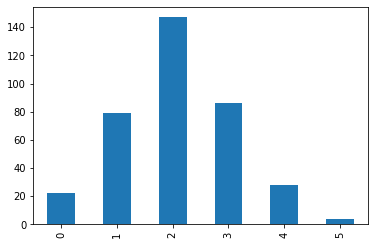

In [20]:
encuestas['svi'].value_counts().sort_index().plot.bar()

In [21]:
# Save preprocessed data
restaurantes_gpd.to_file('outputs/clean_restaurants.geojson', driver='GeoJSON',encoding='utf-8')
encuestas.to_file('outputs/clean_surveys.geojson', driver='GeoJSON',encoding='utf-8')
mercados_gdf.to_file('outputs/clean_markets.geojson', driver='GeoJSON',encoding='utf-8')